# Import Libraries

In [90]:
import os
import datetime
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [91]:
log_dir = r"D:\GLAZE-evaluation\log\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

# Dataset Prep

In [92]:
data_path = r"D:\GLAZE-evaluation\dataset\train"

images = []
labels = []

for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        full_image_path = os.path.join(subfolder_path, image_filename)
        images.append(full_image_path)
        labels.append(subfolder)
        
data = pd.DataFrame({'image': images, 'label': labels})

In [93]:
train_df, valid_test_df = train_test_split(
    data, 
    test_size=0.2, # 20% for validation/test
    stratify=data['label'], 
    random_state=123
)

valid_df, test_df = train_test_split(
    valid_test_df, 
    test_size=0.5, # Split the 20% into two 10% halves
    stratify=valid_test_df['label'], 
    random_state=123
)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Total images found: {len(data)}")
print(f"Train DF size: {len(train_df)}")
print(f"Validation DF size: {len(valid_df)}")
print(f"Test DF size: {len(test_df)}")

Total images found: 400
Train DF size: 320
Validation DF size: 40
Test DF size: 40


In [94]:
data.shape

(400, 2)

In [ ]:
img_size = (299, 299)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2]
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

rain_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    color_mode='rgb', 
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
)

valid_gen = valid_test_datagen.flow_from_dataframe(
    valid_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

test_gen = valid_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image',
    y_col='label',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 320 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [96]:
print(len(train_df))
print(len(valid_df))
print(len(test_df))

320
40
40


# InceptionResnetV2 tuning

In [97]:
base_model = InceptionResNetV2( 
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape )

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [99]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [100]:
x = base_model.output 
x = GlobalAveragePooling2D()(x) # <-- REPLACES FLATTEN 
x = Dense(512, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x) 
predictions = Dense(1, activation='sigmoid')(x)

In [101]:
model = Model(inputs=base_model.input, outputs=predictions)

In [102]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [103]:
checkpoint = ModelCheckpoint(
    'roko_style.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
)

In [104]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=valid_gen,
    validation_steps=valid_gen.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint, early_stopping, reduce_lr, tensorboard_callback]
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5576 - loss: 0.7254
Epoch 1: val_accuracy improved from None to 0.75000, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - accuracy: 0.6156 - loss: 0.6811 - val_accuracy: 0.7500 - val_loss: 0.5344 - learning_rate: 0.0010
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7723 - loss: 0.5273
Epoch 2: val_accuracy improved from 0.75000 to 0.78125, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - accuracy: 0.7469 - loss: 0.5713 - val_accuracy: 0.7812 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7605 - loss: 0.5020
Epoch 3: val_accuracy did not improve from 0.78125
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.7594 - loss: 0.5307 - val_accuracy: 0.7500 - val_loss: 0.5249 - learning_rate: 0.0010
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8082 - loss: 0.4177
Epoch 4: val_accuracy improved from 0.78125 to 0.81250, saving model to roko_style.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.8000 - loss: 0.4313 - val_accuracy: 0.8125 - val_loss: 0.4285 - learning_rate: 0.0010
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8647 - loss: 0.3575
Epoch 5: val_accuracy did not improve from 0.81250
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.8469 - loss: 0.3992 - val_accuracy: 0.7812 - val_loss: 0.5074 - learning_rate: 0.0010


In [105]:
model.load_weights('roko_style.h5')
model.save('roko_style_predictor.h5')

# Evaluation

In [106]:
test_loss, test_acc = model.evaluate(test_gen)
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7750 - loss: 0.4084
Test Accuracy: 0.7750
Test Loss: 0.4084


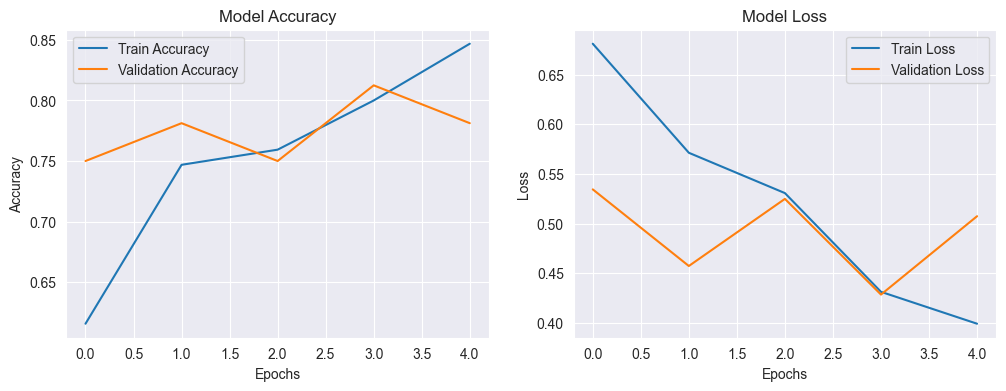

In [107]:
plt.figure(figsize=(12,4))
    
    # Subplot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [108]:
test_gen.reset()
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 11s/step


In [109]:
class_labels = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

              precision    recall  f1-score   support

512-lora-ori       0.50      1.00      0.67        20
     512-ori       0.00      0.00      0.00        20

    accuracy                           0.50        40
   macro avg       0.25      0.50      0.33        40
weighted avg       0.25      0.50      0.33        40



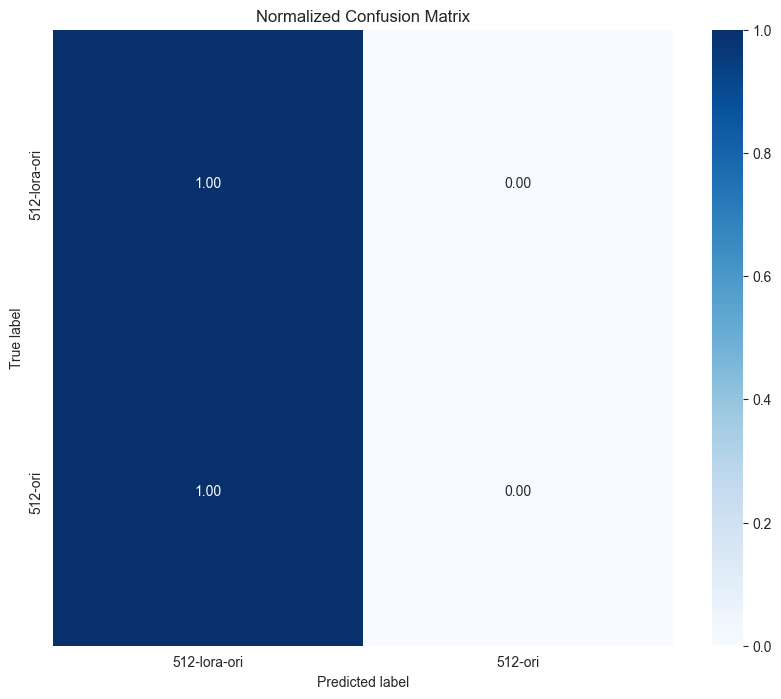

In [110]:
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='.2f', 
            cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()